# Data preparation

(1500, 1500, 3)


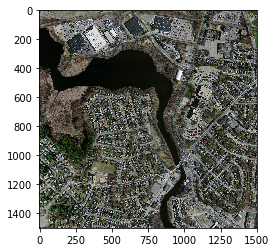

In [82]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
#for filename in os.listdir('data/images'):
#    print(filename)

img=mpimg.imread('data/images/22678915_15.tiff')
print(img.shape)
imgplot = plt.imshow(img)
plt.show()

(1500, 1500, 3)


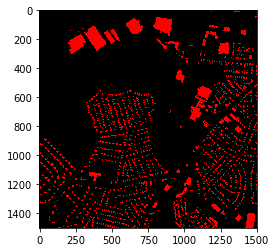

In [11]:
mask=mpimg.imread('data/labels/22678915_15.tif')
print(mask.shape)
imgplot = plt.imshow(mask)
plt.show()

# Model creation


In [80]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

#from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf


def model_create(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)) (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(2, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    print(model.summary())
    return model

# Model fine-tuning

In [81]:
from segmentation_models import FPN
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from keras.utils import to_categorical
import cv2
from PIL import Image
import numpy as np

def model_complile():
    model = FPN(backbone_name='resnet34', encoder_weights='imagenet', freeze_encoder=True)
    model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])
    #print(model.summary())
    return model

# col = Image.open("data/images/22678915_15.tiff") #read image
# gray = col.convert('L')  #conversion to gray scale
# img = gray.point(lambda x: 0 if x<128 else 255, '1')
# img = np.array(img).astype(int)

# img=mpimg.imread('data/images/22678915_15.tiff')

# mask=mpimg.imread('data/labels/22678915_15.tif')

img = Image.open('data/images/22678915_15.tiff')
mask = Image.open('data/labels/22678915_15.tif')

img = img.resize((1024,1024))
mask = mask.resize((1024,1024))
img = np.asarray(img)
mask = np.asarray(mask)
print(img.shape)

mask = mask[:,:,0].reshape(1024,1024)

mask.setflags(write=1)
img.setflags(write=1)
mask[mask > 100] = 1
#mask[mask > 100] = 1
mask = to_categorical(mask, num_classes=2)
#img = to_categorical(img, num_classes=2)
print(img.shape, mask.shape)
mask = mask.reshape(1, 1024,1024,2)
img = img.reshape(1, 1024,1024,3)

# img = (img - img.min()) / (img.max() - img.min())



model = model_create(img.shape[1], img.shape[2], img.shape[3])
#print(model.summary())
model.fit(img, mask, epochs=2)


(1024, 1024, 3)
(1024, 1024, 3) (1024, 1024, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 1024, 1024, 3 0                                            
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, 1024, 1024, 3 0           input_18[0][0]                   
__________________________________________________________________________________________________
conv2d_240 (Conv2D)             (None, 1024, 1024, 1 448         lambda_16[0][0]                  
__________________________________________________________________________________________________
dropout_109 (Dropout)           (None, 1024, 1024, 1 0           conv2d_240[0][0]                 
_____________________________________________________________